In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


2025-07-02 19:12:54.510742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751483574.704151      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751483574.757049      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_path = "/kaggle/input/intel-image-classification/seg_test/seg_test"
pred_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"

In [3]:
Classes = {name: idx for idx, name in enumerate(os.listdir(train_path))}

In [4]:
print(Classes)

{'mountain': 0, 'street': 1, 'buildings': 2, 'sea': 3, 'forest': 4, 'glacier': 5}


## print the number of each class in training data

In [5]:
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class '{class_name}': {num_images} images")

Class 'mountain': 2512 images
Class 'street': 2382 images
Class 'buildings': 2191 images
Class 'sea': 2274 images
Class 'forest': 2271 images
Class 'glacier': 2404 images


## print the number of each class in test data

In [6]:
for class_name in os.listdir(test_path):
    class_path = os.path.join(test_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class '{class_name}': {num_images} images")

Class 'mountain': 525 images
Class 'street': 501 images
Class 'buildings': 437 images
Class 'sea': 510 images
Class 'forest': 474 images
Class 'glacier': 553 images


In [7]:
size = []
for folder in os.listdir(train_path):
    class_path = os.path.join(train_path, folder)
    if os.path.isdir(class_path):
        for img in os.listdir(class_path):
            img_path = os.path.join(class_path, img)
            try:
                image = plt.imread(img_path)
                size.append(image.shape)
            except Exception as e:
                continue

print(pd.Series(size).value_counts())

(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(144, 150, 3)        2
(143, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(108, 150, 3)        2
(136, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(100, 150, 3)        1
(141, 150, 3)        1
(103, 150, 3)        1
(145, 150, 3)        1
(147, 150, 3)        1
(131, 150, 3)        1
(81, 150, 3)         1
(140, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(149, 150, 3)        1
(110, 150, 3)        1
(105, 150, 3)        1
(97, 150, 3)         1
(120, 150, 3)        1
(76, 150, 3)         1
(119, 150, 3)        1
(102, 150, 3)        1
Name: count, dtype: int64


In [8]:
size = []
for folder in os.listdir(test_path):
    class_path = os.path.join(test_path, folder)
    if os.path.isdir(class_path):
        for img in os.listdir(class_path):
            img_path = os.path.join(class_path, img)
            try:
                image = plt.imread(img_path)
                size.append(image.shape)
            except Exception as e:
                continue

print(pd.Series(size).value_counts())

(150, 150, 3)    2993
(81, 150, 3)        1
(131, 150, 3)       1
(141, 150, 3)       1
(149, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(72, 150, 3)        1
Name: count, dtype: int64


In [9]:
IMG_SIZE = (150, 150)
X_trainL = []
y_trainL = []

for class_name, class_index in Classes.items():
    class_path = os.path.join(train_path, class_name)
    for img_name in  tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
        img_path = os.path.join(class_path, img_name)
        try:
            img = cv2.imread(img_path)
            resized_img= cv2.resize(img, IMG_SIZE)
            X_trainL.append(resized_img)
            y_trainL.append(class_index)
        except Exception as e:
            continue  # continue if error

Loading glacier: 100%|██████████| 2404/2404 [00:03<00:00, 722.83it/s]


In [10]:
X_train = np.array(X_trainL)
X_train.shape

(14034, 150, 150, 3)

In [11]:
y_train = np.array(y_trainL)
y_train.shape

(14034,)

In [12]:
def getname(label):
    for class_name, class_index in Classes.items():
        if label == class_index:
            return class_name

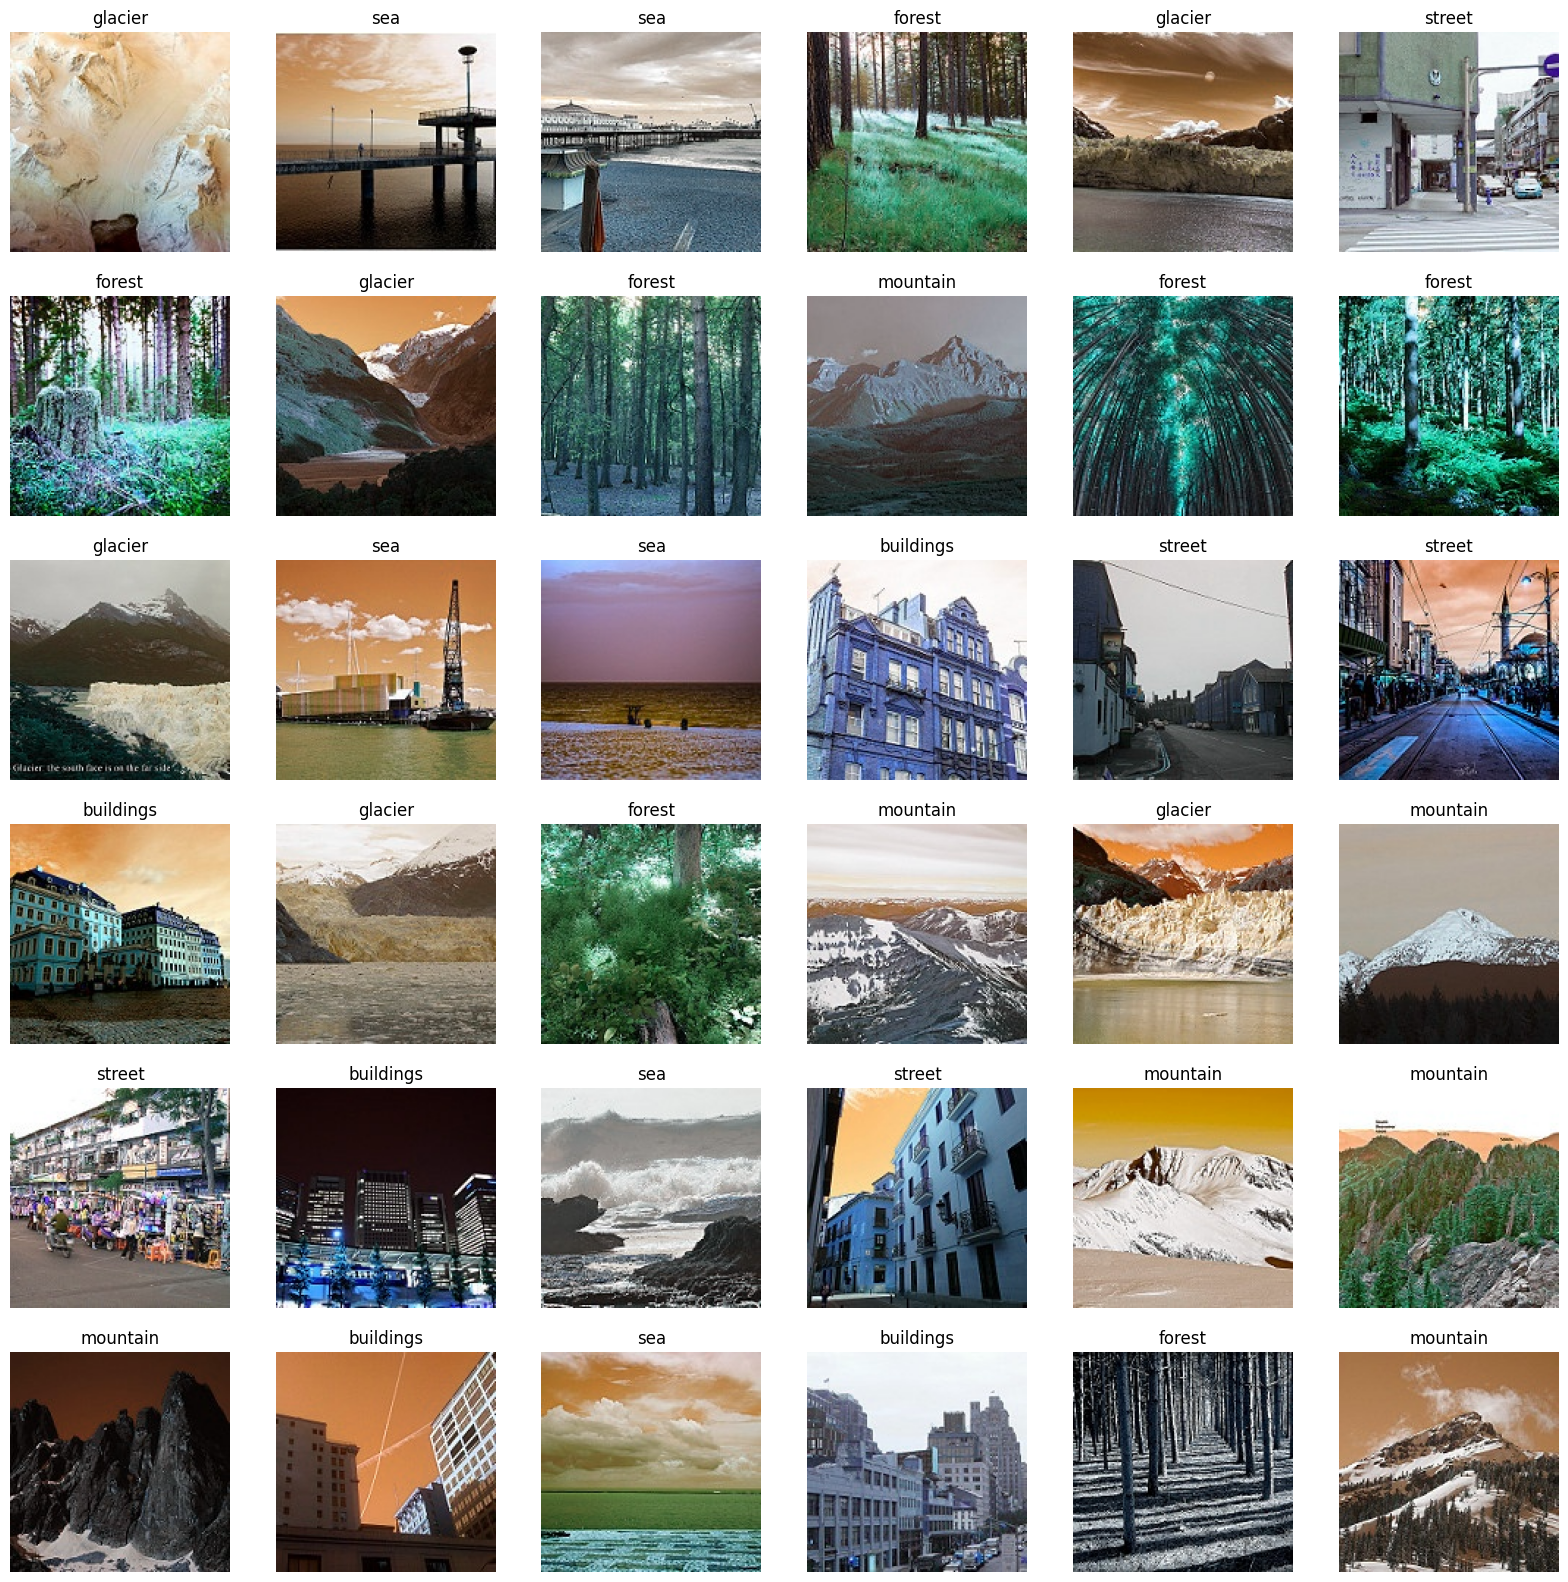

In [13]:
plt.figure(figsize=(20, 20))

for n, i in enumerate(list(np.random.randint(0, len(X_train), 36))):
    plt.subplot(6, 6, n + 1)             # Create a 6x6 grid of subplots
    plt.imshow(X_train[i])              # Show the image at index i
    plt.axis('off')
    plt.title(getname(y_train[i]))      # Title from label using getcode()

In [14]:
IMG_SIZE = (150, 150)
X_testL = []
y_testL = []

for class_name, class_index in Classes.items():
    class_path = os.path.join(test_path, class_name)
    for img_name in  tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
        img_path = os.path.join(class_path, img_name)
        try:
            img = cv2.imread(img_path)
            resized_img= cv2.resize(img, IMG_SIZE)
            X_testL.append(resized_img)
            y_testL.append(class_index)
        except Exception as e:
            continue  # continue if error

Loading glacier: 100%|██████████| 553/553 [00:00<00:00, 770.24it/s]


In [15]:
X_test = np.array(X_testL)
X_test.shape

(3000, 150, 150, 3)

In [16]:
y_test = np.array(y_testL)
y_test.shape

(3000,)

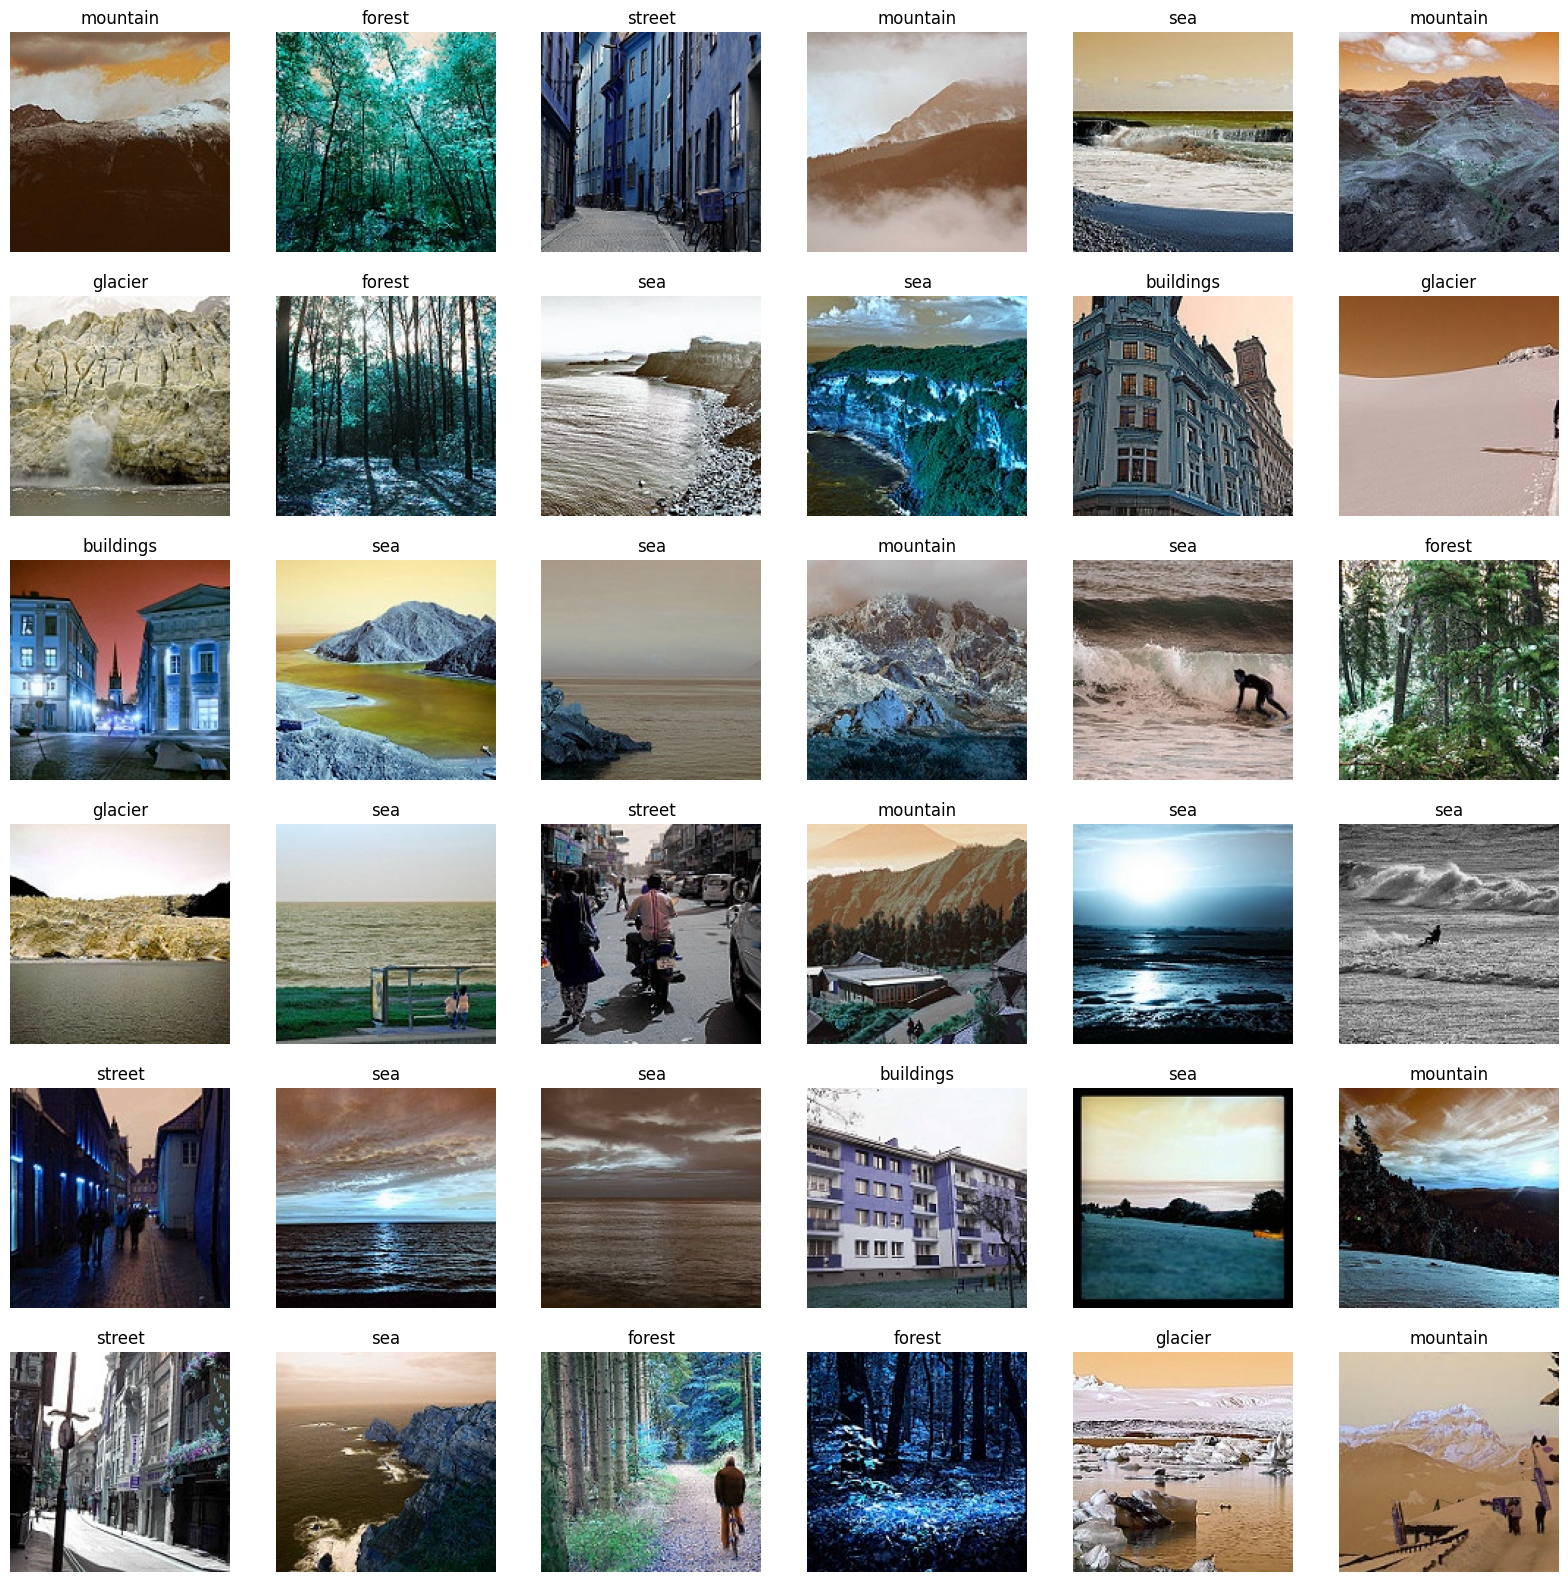

In [17]:
plt.figure(figsize=(20, 20))  # Set figure size

# Randomly pick 36 indices from X_train
for n, i in enumerate(list(np.random.randint(0, len(X_test), 36))):
    plt.subplot(6, 6, n + 1)             # Create a 6x6 grid of subplots
    plt.imshow(X_test[i])              # Show the image at index i
    plt.axis('off')
    plt.title(getname(y_test[i]))      # Title from label using getcode()

## Noramlize

In [18]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [19]:
# X_train = X_train * 255.0
# X_test = X_test * 255.0

In [20]:
X_train[0][0][0]

array([0.84705882, 0.79607843, 0.74117647])

## saving X_train, y_train

In [21]:
import pickle
# Save X_train
with open('/kaggle/working/X_train.pickle', 'wb') as f:
    pickle.dump(X_train, f)
    
# Save y_train
with open('/kaggle/working/y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

## load X_train, y_train

In [22]:
# Load X_train
with open('/kaggle/working/X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)

# Load y_train
with open('/kaggle/working/y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)

## saving X_test, y_test

In [23]:
import pickle

# Save X_train
with open("/kaggle/working/X_test.pickle", "wb") as f:
    pickle.dump(X_test, f)

# Save y_train
with open("/kaggle/working/y_test.pickle", "wb") as f:
    pickle.dump(y_test, f)

## load X_test, y_test

In [24]:
# Load X_train
with open('/kaggle/working/X_test.pickle', 'rb') as f:
    X_train = pickle.load(f)

# Load y_train
with open('/kaggle/working/y_test.pickle', 'rb') as f:
    y_train = pickle.load(f)

In [25]:
model1 = Sequential([
    Input(shape=(150, 150, 3)),
    
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((4, 4)),

    # Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    # MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(6, activation='softmax')
])


I0000 00:00:1751483821.631101      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751483821.633227      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [26]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,682,374 (10.23 MB)

 Trainable params: 2,682,374 (10.23 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model1.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1, shuffle=True)

Epoch 1/10


I0000 00:00:1751483829.159722      66 service.cc:148] XLA service 0x79d9ac00bd50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751483829.160492      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751483829.160513      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751483829.571454      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


10/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1831 - loss: 2.3648

I0000 00:00:1751483833.501315      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.2730 - loss: 1.8369 - val_accuracy: 0.0167 - val_loss: 1.7369
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5402 - loss: 1.2096 - val_accuracy: 0.0300 - val_loss: 1.6697
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6362 - loss: 0.9935 - val_accuracy: 0.1867 - val_loss: 1.6216
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6982 - loss: 0.8168 - val_accuracy: 0.3200 - val_loss: 1.5243
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7353 - loss: 0.7439 - val_accuracy: 0.5500 - val_loss: 1.2275
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8095 - loss: 0.5510 - val_accuracy: 0.3367 - val_loss: 1.5679
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8145 - loss: 0.5264 - val_accuracy: 0.5000 - val_loss: 1.5097
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8575 - loss: 0.4529 - val_accuracy: 0.5100 - val_loss: 1

In [29]:
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9559 - loss: 0.1745
Test Loss: 0.3510
Test Accuracy: 0.8943


## Saving the model

In [30]:
model1.save('/kaggle/working/my_model1.h5')

In [31]:
model2 = Sequential([
    Input(shape=(150, 150, 3)),

    Conv2D(200, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(150, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((4, 4)),

    Conv2D(120, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

In [32]:
from tensorflow.keras.optimizers import Adam
model2.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 150, 150, 200)       │           5,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 150)       │         270,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 37, 37, 150)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 37, 37, 120)         │         162,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 18, 18, 120)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 38880)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       4,976,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,423,284 (20.69 MB)

 Trainable params: 5,423,284 (20.69 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model2.fit(X_train, y_train, batch_size=32, epochs=15 , validation_split=0.1, shuffle=True)

Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 61s 477ms/step - accuracy: 0.3023 - loss: 1.9050 - val_accuracy: 0.0000e+00 - val_loss: 1.8272
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.5215 - loss: 1.3972 - val_accuracy: 0.0100 - val_loss: 1.6267
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 294ms/step - accuracy: 0.5824 - loss: 1.2345 - val_accuracy: 0.0300 - val_loss: 2.0570
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - accuracy: 0.6245 - loss: 1.1106 - val_accuracy: 0.1967 - val_loss: 1.4091
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - accuracy: 0.6754 - loss: 1.0007 - val_accuracy: 0.1300 - val_loss: 1.8556
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 288ms/step - accuracy: 0.7008 - loss: 0.9175 - val_accuracy: 0.2933 - val_loss: 1.7143
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 288ms/step - accuracy: 0.7503 - loss: 0.7875 - val_accuracy: 0.5167 - val_loss: 1.3995
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 284ms/step - accuracy: 0.7608 - loss: 0.7444 - val_

In [35]:
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9483 - loss: 0.2496
Test Loss: 0.3079
Test Accuracy: 0.9433
